# Let's build all kind of auto-de models.

In [1]:
#imports
import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from ioh_xplainer import explainer
import pandas as pd
import ioh
from scipy.stats import qmc
from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid
from IPython.display import display
from time import monotonic
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from config import de_features, de_explainer
ela_df = pd.read_pickle("../output/ela-features-de.pkl")
ela_df = ela_df.loc[:, ~ela_df.columns.str.match('.*costs_runtime')]

ela_df[['dim','fid',*de_features, 'auc']]

,dim,fid,F,CR,lambda_,mutation_base,mutation_reference,mutation_n_comps,use_archive,crossover,adaptation_method,lpsr,auc
0,5,1,0.25,0.50,8,best,pbest,2,False,bin,shade,False,0.974087
1,5,1,0.25,0.50,10,best,rand,2,False,bin,nan,False,0.973439
2,5,1,0.25,0.50,8,best,rand,2,True,bin,nan,False,0.973851
3,5,1,0.25,0.75,8,best,rand,2,True,exp,nan,False,0.973927
4,5,1,0.25,0.25,8,best,nan,2,True,bin,nan,False,0.972835
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,30,24,0.75,0.75,14,target,best,1,False,exp,shade,False,0.000478
236,30,24,0.25,0.75,14,best,rand,1,True,exp,shade,False,0.001390
237,30,24,1.25,0.75,14,best,nan,1,True,exp,shade,False,0.000586
238,30,24,0.50,1.00,14,best,rand,2,False,exp,shade,False,0.000200


In [3]:
#load explainer
data_file = "de_final_processed.pkl" #read in modular DE data
de_explainer.load_results(data_file)
de_explainer.df.loc[de_explainer.df["dim"] == 30,'auc'] = de_explainer.df.loc[de_explainer.df["dim"] == 30,'aucLarge']

In [4]:
for f in de_features:
    print(f, ela_df[f].unique())

categorical_columns = de_features

df = ela_df.copy()
for cat in categorical_columns:
    print(cat)
    df[cat] = df[cat].astype('category')
    print(df[cat].unique())
    print(df[cat].cat.codes.unique())

ela_df_cat = ela_df.copy()
ela_df_cat[de_features] = ela_df_cat[de_features].apply(lambda col:pd.Categorical(col).codes)

F [0.25 0.75 0.5  1.75 1.25]
CR [0.5  0.75 0.25 0.05 1.  ]
lambda_ [  8  10  50  14  60 300]
mutation_base ['best' 'target' 'rand']
mutation_reference ['pbest' 'rand' 'nan' 'best']
mutation_n_comps [2 1]
use_archive [False  True]
crossover ['bin' 'exp']
adaptation_method ['shade' 'nan' 'jDE']
lpsr [False  True]
F
[0.25, 0.75, 0.50, 1.75, 1.25]
Categories (5, float64): [0.25, 0.50, 0.75, 1.25, 1.75]
[0 2 1 4 3]
CR
[0.50, 0.75, 0.25, 0.05, 1.00]
Categories (5, float64): [0.05, 0.25, 0.50, 0.75, 1.00]
[2 3 1 0 4]
lambda_
[8, 10, 50, 14, 60, 300]
Categories (6, int64): [8, 10, 14, 50, 60, 300]
[0 1 3 2 4 5]
mutation_base
['best', 'target', 'rand']
Categories (3, object): ['best', 'rand', 'target']
[0 2 1]
mutation_reference
['pbest', 'rand', 'nan', 'best']
Categories (4, object): ['best', 'nan', 'pbest', 'rand']
[2 3 1 0]
mutation_n_comps
[2, 1]
Categories (2, int64): [1, 2]
[1 0]
use_archive
[False, True]
Categories (2, bool): [False, True]
[0 1]
crossover
['bin', 'exp']
Categories (2, ob

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


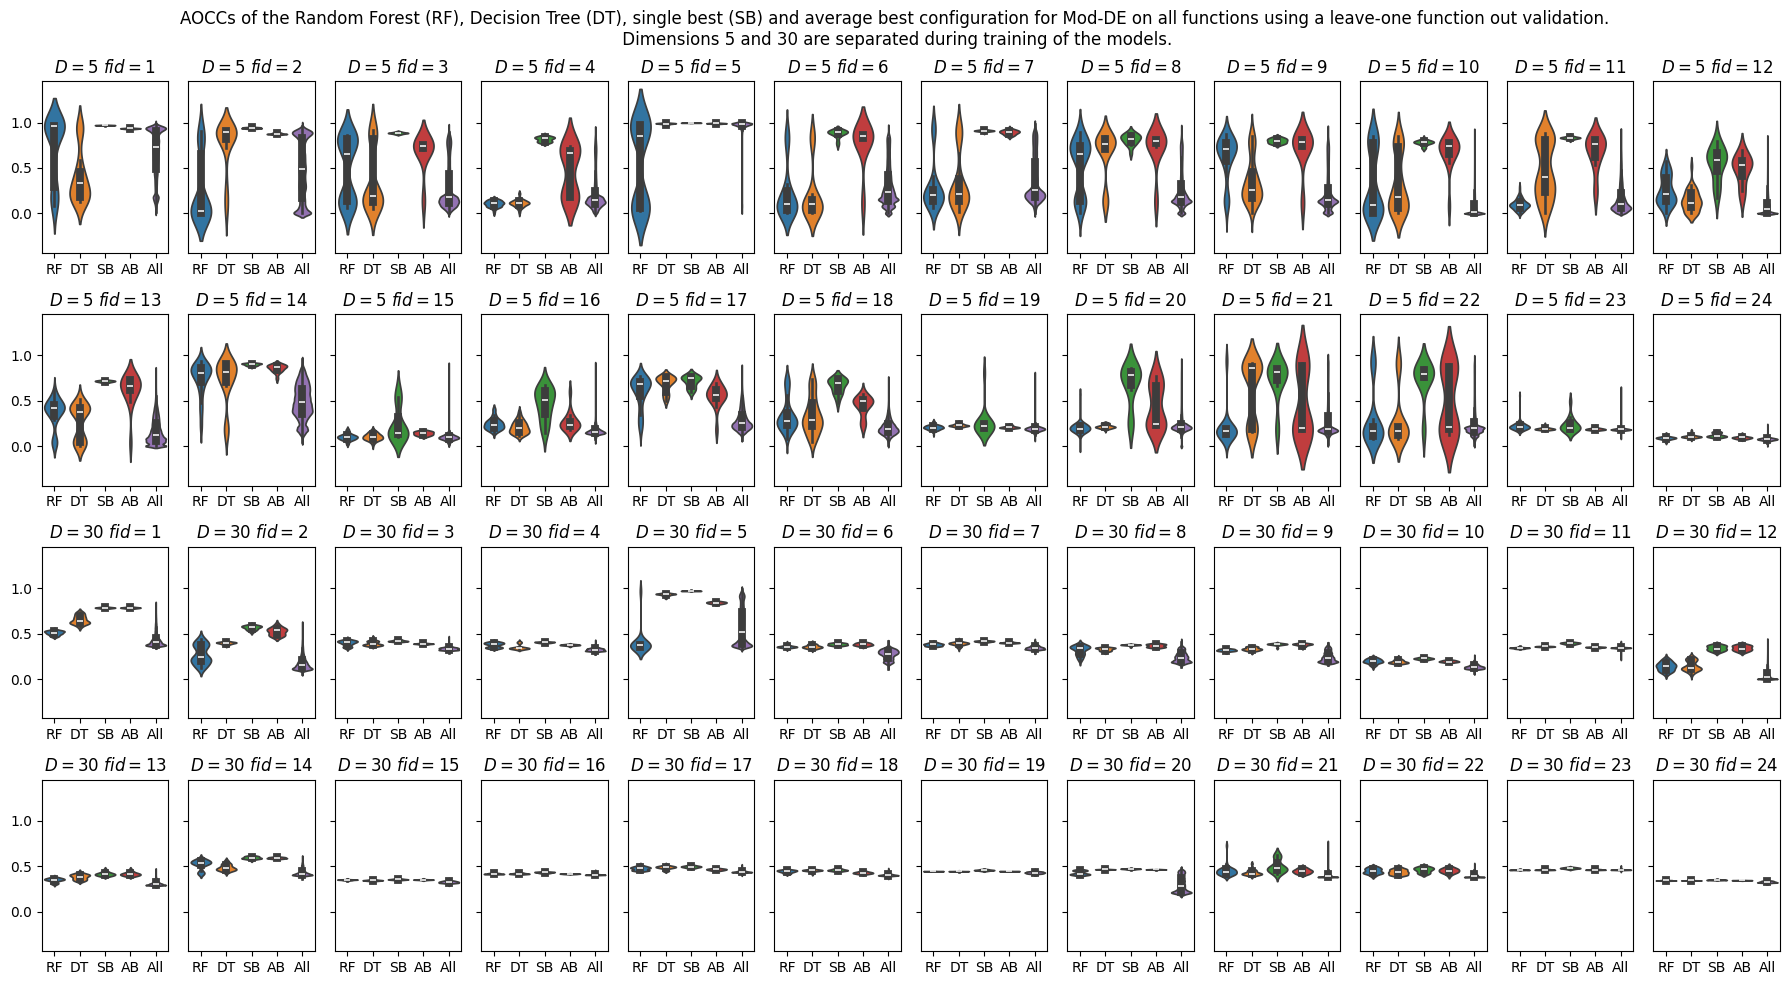

In [5]:

#leave one function out 
def predToNames(y, dim):

    mapping = [[0.25, 0.5, 0.75, 1.25, 1.75], [0.05, 0.25, 0.5,  0.75, 1.], [ 8, 10, 14, 50, 60, 300],['best', 'rand', 'target'], ['best', 'nan', 'pbest', 'rand'], 
                [1, 2], [False, True], ['bin', 'exp'], ['jDE', 'nan', 'shade'], [False, True]]
    newy = {}
    i = 0
    for f in de_features:
        newy[f] = mapping[i][y[i]]
        i+=1
    #transform a numerical representation back to the categorical names
    return newy

AOCC_distances_to_opt = {'d5': {'AB':[], 'DT':[], 'RF':[]}, 'd30': {'AB':[], 'DT':[], 'RF':[]} }


#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AOCCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-DE on all functions using a leave-one function out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB', 'All'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['All'] = pd.Series(de_explainer.df[(de_explainer.df['fid'] == fid) & (de_explainer.df['dim'] == dim)]['auc'].values)
        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        df = ela_df_cat[ela_df_cat['dim'] == dim]
        X_train = df[df['fid'] != fid].copy().drop(['fid','iid','auc',*de_features], axis=1)
        y_train = df[df['fid'] != fid][de_features]
        X_test = df[df['fid'] == fid].copy().drop(['fid','iid','auc',*de_features], axis=1)
        y_test = df[df['fid'] == fid][de_features]

        X_train.replace([np.inf, -np.inf], 0, inplace=True)
        X_test.replace([np.inf, -np.inf], 0, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        #y_train[features] = y_train[features].apply(lambda col:pd.Categorical(col).codes)
        #y_test[features] = y_test[features].apply(lambda col:pd.Categorical(col).codes)
    
        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)

        #RFx
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_red_rf = rf.predict(X_test)

        iid = 1
        all_aucs = []
        all_aucs_rf = []
        for y in y_pred:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid)
            all_aucs.extend(aucs.values)
            #print(all_aucs)
        for y in y_red_rf:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid)
            all_aucs_rf.extend(aucs.values)
            #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs))
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf))
        #print(all_aucs)

        for iid in range(1,6):
            #get best per idd
            _, df_single_best_iid = de_explainer.get_single_best_for_iid(fid, iid, dim)
            best_median = np.median(df_single_best_iid['auc'].values)
            DT_median = np.array(all_aucs)[3*(iid-1):3*iid]
            RF_median = np.array(all_aucs_rf)[3*(iid-1):3*iid]
            AOCC_distances_to_opt[f'd{dim}']['DT'].append((best_median - np.median(DT_median)))
            AOCC_distances_to_opt[f'd{dim}']['RF'].append((best_median - np.median(RF_median)))
            AB_median = np.median(df_avg_best[(df_avg_best['fid'] == fid) & (df_avg_best['iid'] == iid)]['auc'].values)
            AOCC_distances_to_opt[f'd{dim}']['AB'].append((best_median - AB_median))

        sns.violinplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df )#, showmeans=True,
                    # meanprops={"marker":"o",
                    #    "markerfacecolor":"white", 
                    #    "markeredgecolor":"black",
                    #   "markersize":"6"})  
        # sns.boxplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
        #             meanprops={"marker":"o",
        #                "markerfacecolor":"white", 
        #                "markeredgecolor":"black",
        #               "markersize":"6"})  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.savefig("../output/de_img_new/classifiers-fid.pdf")
plt.savefig("../output/de_img_new/classifiers-fid.png")
plt.show()

plt.clf()
plt.close()

        

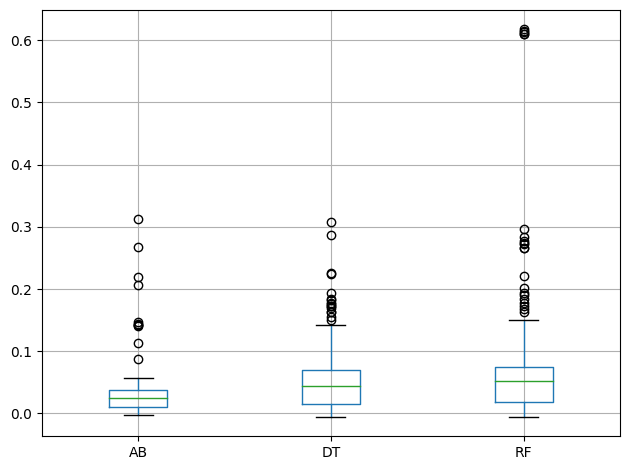

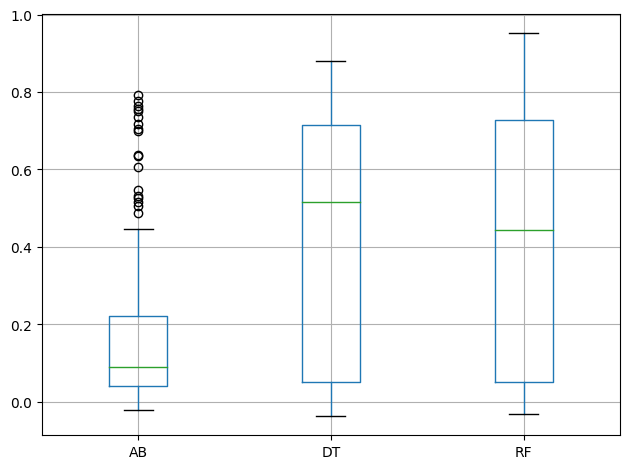

In [6]:
AOCC_df_30d = pd.DataFrame(AOCC_distances_to_opt['d30'])
AOCC_df_30d.boxplot()
plt.tight_layout()
plt.savefig("../output/de_img_new/classifiers-fid-loss-d30.png")
plt.show()

AOCC_df_5d = pd.DataFrame(AOCC_distances_to_opt['d5'])
AOCC_df_5d.boxplot()
plt.tight_layout()
plt.savefig("../output/de_img_new/classifiers-fid-loss-d5.png")
plt.show()

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


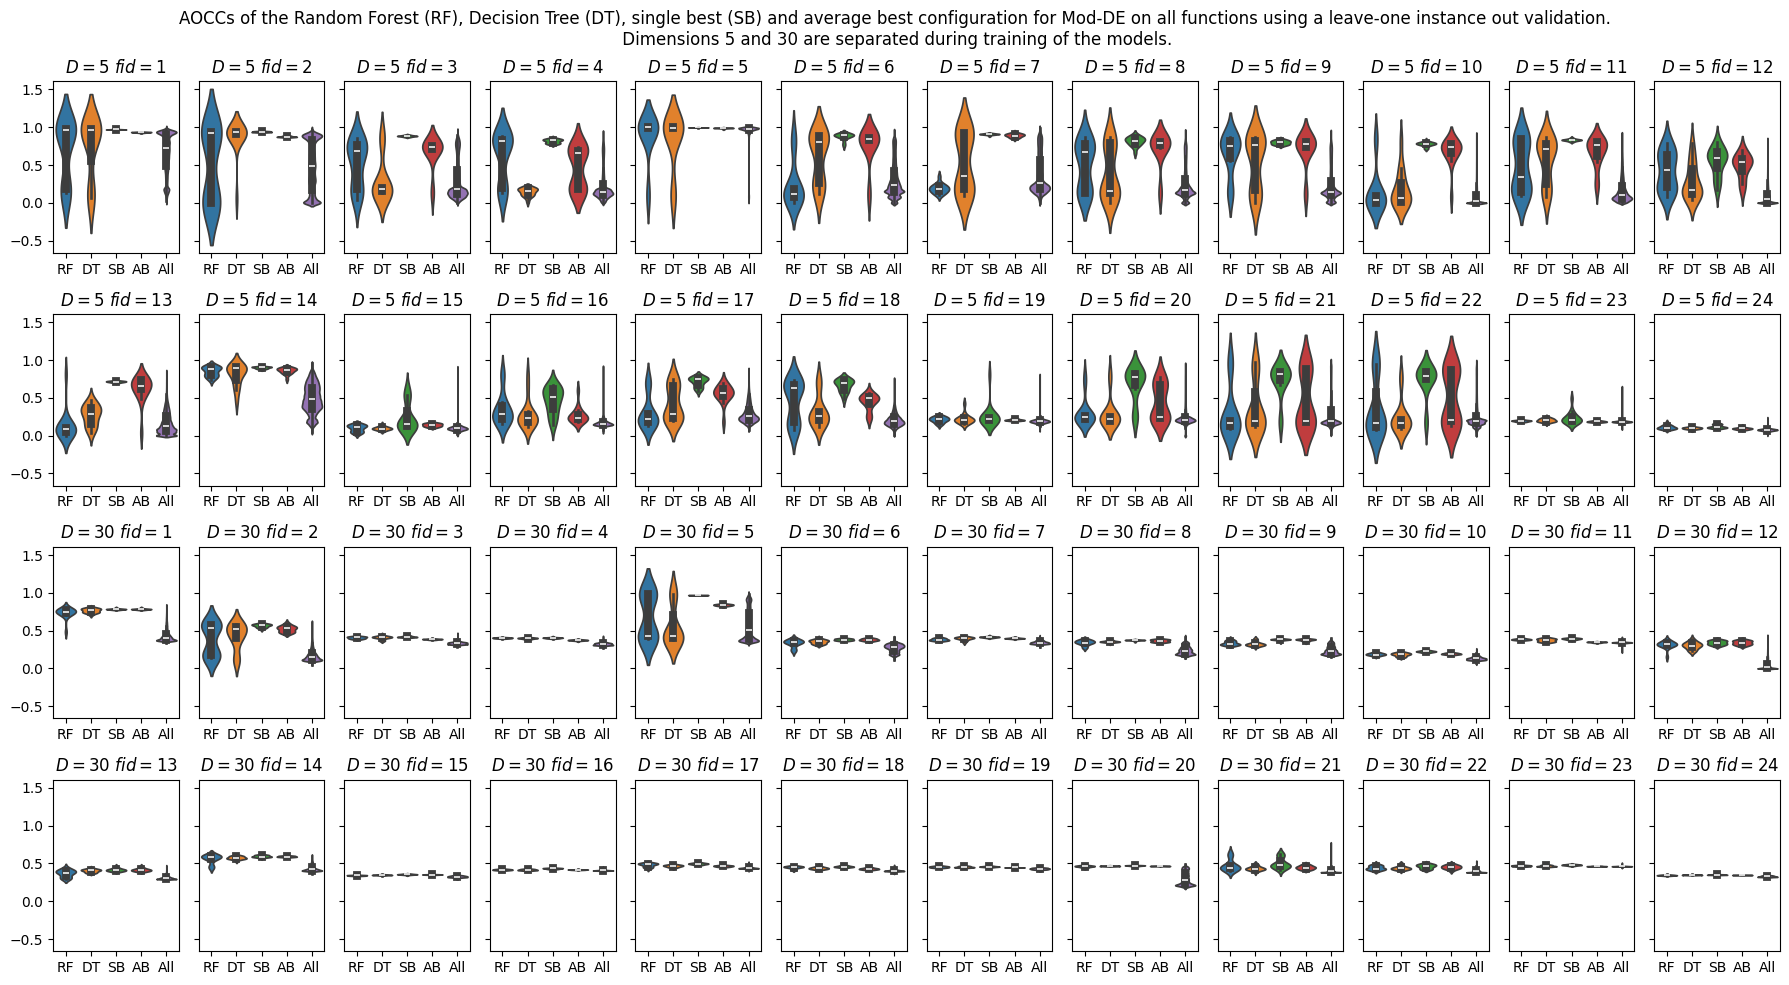

In [7]:
#Leave one instance out
#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AOCCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-DE on all functions using a leave-one instance out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    df = ela_df_cat[ela_df_cat['dim'] == dim].copy()
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB', 'All'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['All'] = pd.Series(de_explainer.df[(de_explainer.df['fid'] == fid) & (de_explainer.df['dim'] == dim)]['auc'].values)

        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        all_aucs = []
        all_aucs_rf = []
        for iid in [1,2,3,4,5]:
            X_train = df[df['iid'] != iid].copy().drop(['fid','iid','auc',*de_features], axis=1)
            y_train = df[df['iid'] != iid][de_features]
            X_test = df[(df['iid'] == iid) & (df['fid'] == fid)].copy().drop(['fid','iid','auc',*de_features], axis=1)
            y_test = df[(df['iid'] == iid) & (df['fid'] == fid)][de_features]

            X_train.replace([np.inf, -np.inf], 0, inplace=True)
            X_test.replace([np.inf, -np.inf], 0, inplace=True)
            X_train.fillna(0, inplace=True)
            X_test.fillna(0, inplace=True)

            dtree = DecisionTreeClassifier(max_depth=7)
            dtree.fit(X_train, y_train)

            #RF
            rf = RandomForestClassifier()
            rf.fit(X_train, y_train)

            #DT
            y_pred = dtree.predict(X_test)

            #RF
            y_red_rf = rf.predict(X_test)

        
            for y in y_pred:
                #print(y)
                conf = predToNames(y, dim)
                #print(conf)
                aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
                all_aucs.extend(aucs.values)
                #print(all_aucs)
            for y in y_red_rf:
                #print(y)
                conf = predToNames(y, dim)
                #print(conf)
                aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
                all_aucs_rf.extend(aucs.values)
                #print(all_aucs)

            _, df_single_best_iid = de_explainer.get_single_best_for_iid(fid, iid, dim)
            best_median = np.median(df_single_best_iid['auc'].values)
            DT_median = np.array(all_aucs)
            RF_median = np.array(all_aucs_rf)
            AOCC_distances_to_opt[f'd{dim}']['DT'].append((best_median - np.median(DT_median)))
            AOCC_distances_to_opt[f'd{dim}']['RF'].append((best_median - np.median(RF_median)))
            AB_median = np.median(df_avg_best[(df_avg_best['fid'] == fid) & (df_avg_best['iid'] == iid)]['auc'].values)
            AOCC_distances_to_opt[f'd{dim}']['AB'].append((best_median - AB_median))

        box_plot_df['DT'] = pd.Series(np.array(all_aucs))
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf))
        
        sns.violinplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df)#, showmeans=True,
                    # meanprops={"marker":"o",
                    #    "markerfacecolor":"white", 
                    #    "markeredgecolor":"black",
                    #   "markersize":"6"})
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.savefig("../output/de_img_new/classifiers-iid.pdf")
plt.savefig("../output/de_img_new/classifiers-iid.png")
plt.show()

plt.clf()
plt.close()

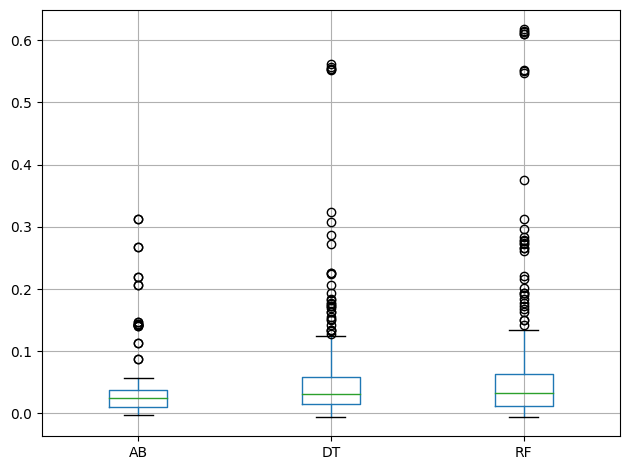

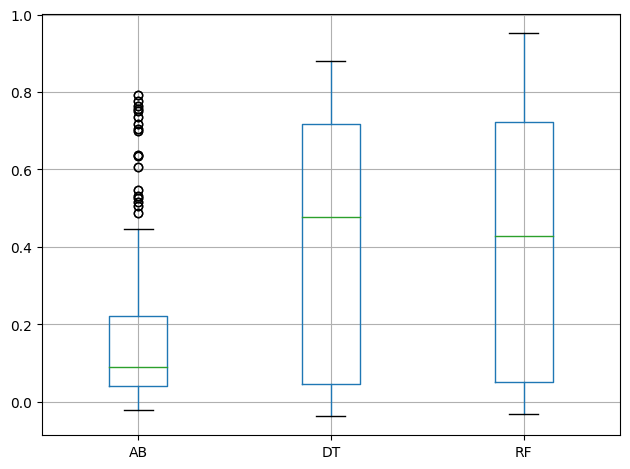

In [8]:
AOCC_df_30d = pd.DataFrame(AOCC_distances_to_opt['d30'])
AOCC_df_30d.boxplot()
plt.tight_layout()
plt.savefig("../output/de_img_new/classifiers-iid-loss-d30.png")
plt.show()

AOCC_df_5d = pd.DataFrame(AOCC_distances_to_opt['d5'])
AOCC_df_5d.boxplot()
plt.tight_layout()
plt.savefig("../output/de_img_new/classifiers-iid-loss-d5.png")
plt.show()

In [5]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

#plot decision tree
import dtreeviz

mapping = [[0.25, 0.5, 0.75, 1.25, 1.75], [0.05, 0.25, 0.5,  0.75, 1.], [ 8, 10, 14, 50, 60, 300],['best', 'rand', 'target'], ['best', 'nan', 'pbest', 'rand'], 
            [1, 2], [False, True], ['bin', 'exp'], ['jDE', 'nan', 'shade'], [False, True]]

for dim in [5,30]:
    df = ela_df_cat[ela_df_cat['dim'] == dim].copy()

    X_train = df.copy().drop(['fid','iid','auc',*de_features], axis=1)
    y_train = df[de_features]

    X_train.replace([np.inf, -np.inf], 0, inplace=True)
    X_train.fillna(0, inplace=True)
    fi = 0
    for f in de_features:
        
        old_values = y_train[f].unique()
        new_values = np.arange(0,len(y_train[f].unique()))

        y = y_train.copy()
        for n in new_values:
            y.loc[y_train[f] == old_values[n], f] = n #update 4 to 3
        labels = list(np.array(mapping[fi])[old_values])
        #print(old_values, new_values, labels)

        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y[f])
        print(f"d{dim} f{f} score", dtree.score(X_train, y[f]))

        viz_model = dtreeviz.model(dtree, X_train, y[f],
            target_name=f,
            feature_names=X_train.columns,
            class_names=labels 
        )
        v = viz_model.view(scale=1.0)
        v.save(f"../output/trees_de/d{dim}-f{f}.svg")
        fi += 1
    
    #fig = plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(dtree, 
    #                feature_names=X_train.columns,  
    #                class_names=features,
    #                filled=True)
    #plt.show()

d5 fF score 0.9583333333333334


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fCR score 0.9416666666666667


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 flambda_ score 0.9916666666666667


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmutation_base score 0.9083333333333333


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmutation_reference score 0.7916666666666666


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmutation_n_comps score 0.9833333333333333


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fuse_archive score 0.9833333333333333


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fcrossover score 0.975


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fadaptation_method score 0.975


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 flpsr score 0.975


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fF score 0.9666666666666667


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fCR score 0.7833333333333333


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 flambda_ score 1.0


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmutation_base score 0.9666666666666667


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmutation_reference score 0.9583333333333334


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmutation_n_comps score 0.95


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fuse_archive score 1.0


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fcrossover score 0.9916666666666667


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fadaptation_method score 0.9666666666666667


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 flpsr score 1.0


/home/neocortex/.cache/pypoetry/virtualenvs/ioh-xplainer-KJlu7ll7-py3.8/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
